In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import sys
sys.path.append("../")

In [2]:
from utils.common_settings import *
from data_loader import data_loader_ml, data_loader_dl
from data import data_factory
from utils import path_definitions
from utils.cv_split import judge_corner_cvsplit
from algorithm.base import DepressionDetectionAlgorithmBase
from data_loader.data_loader_ml import DatasetDict, DataRepo
from utils import train_eval_pipeline

In [63]:
import matplotlib as mpl
from matplotlib import rcParams
mpl.rcParams.update(mpl.rcParamsDefault)

plt.style.use(['science', "grid"])

plt.rcParams["font.family"] = "Times New Roman"

# Data Loading

In [4]:
ds_keys = ["INS-W_1","INS-W_2","INS-W_3","INS-W_4"]
colors = [ "#d7191c", "#fdae61", "#1a9641", "#2b83ba"]

In [15]:
dataset_dict_raw = data_loader_ml.data_loader_raw(
    ds_keys_list = ds_keys,
    verbose = False
)

In [6]:
dataset_dict = data_loader_ml.data_loader(ds_keys_dict={
    "dep_weekly": ds_keys}, flag_more_feat_types=True, verbose = False)

In [7]:
dataset_dict_weekly = dataset_dict["dep_weekly"]

## Feature Definition

In [8]:
df_tmp = dataset_dict_raw[ds_keys[0]]
feature_columns_full = sorted(list(set(df_tmp.columns).difference(set(["pid", "date", "device_type", "dep"])))) # remove non-feature columns
feature_columns_numeric = [f for f in feature_columns_full if df_tmp[f].dtype.kind in "bifc"]
feature_columns_allday = [f for f in feature_columns_numeric if f.endswith(":allday")]

In [9]:
feature_columns_filtered = []
for f in feature_columns_allday:
    na_rate = [ dataset_dict_raw[ds_key][f].isna().sum() / dataset_dict_raw[ds_key].shape[0] for ds_key in ds_keys]
    if max(na_rate) < 0.9:
        feature_columns_filtered.append(f)

In [10]:
timerange_list = ["allday", "morning", "afternoon", "evening", "night", "14dhist"]
feature_columns_filtered_timeranges_dict = {}
for timerange in timerange_list:
    feature_columns_filtered_timeranges_dict[timerange] = deepcopy([f.replace(f":allday", f":{timerange}") for f in feature_columns_filtered])
feature_columns_filtered_timeranges = np.concatenate(list(feature_columns_filtered_timeranges_dict.values()))

In [11]:
feature_columns_nonorm = [f for f in feature_columns_filtered if f.endswith(":allday") and not f.endswith("_norm:allday")]
feature_columns_norm = [f for f in feature_columns_filtered if f.endswith("_norm:allday")]

In [12]:
dataset_dict_raw_filtered = {}
dataset_dict_raw_filtered_withna = {}
for ds_key in ds_keys:
    df_tmp = dataset_dict_raw[ds_key][feature_columns_nonorm]
    df_tmp_narate = df_tmp.apply(lambda row : pd.isna(row).sum() / df_tmp.shape[1], axis = 1)
    dataset_dict_raw_filtered_withna[ds_key] = deepcopy(dataset_dict_raw[ds_key][["pid", "date"] + feature_columns_numeric][df_tmp_narate < 0.8])
    dataset_dict_raw_filtered_withna[ds_key]["date"] = pd.to_datetime(dataset_dict_raw_filtered_withna[ds_key]["date"])
    dataset_dict_raw_filtered[ds_key] = deepcopy(dataset_dict_raw_filtered_withna[ds_key].fillna(dataset_dict_raw_filtered_withna[ds_key].median()))

### NA Analysis

In [16]:
dataset_dict_raw_filtered_tmp = {}
for ds_key in ds_keys:
    df_tmp = dataset_dict_raw[ds_key][feature_columns_nonorm]
    df_tmp_narate = df_tmp.apply(lambda row : pd.isna(row).sum() / df_tmp.shape[1], axis = 1)
    dataset_dict_raw_filtered_tmp[ds_key] = dataset_dict_raw[ds_key][["pid", "date"] + feature_columns_numeric][df_tmp_narate < 0.8]

narate_pivot_list = []
narate_pivot2_list = []
narate_pivot3_list = []

for ds_key in ["INS-W_1", "INS-W_2", "INS-W_3", "INS-W_4"]:
    f = "f_loc:phone_locations_doryab_avgspeed:allday"
    df_pivot = dataset_dict_raw_filtered_tmp[ds_key].pivot(index= "pid", columns="date", values=f)
    narate_pivot = df_pivot.isna().sum().sum() / (df_pivot.shape[0] * df_pivot.shape[1])
    narate_pivot_list.append(narate_pivot)
print(np.mean(narate_pivot_list), np.std(narate_pivot_list))

0.14475317724455725 0.03957688470401072


## Data Amount Analysis

In [70]:
count_dict = {}
for ii, ds_key in enumerate(ds_keys):
    count_dict[ds_key] = dataset_dict_raw_filtered[ds_key].groupby("pid").count().iloc[:,0]

In [71]:
label_count_dict = {}
for ii, ds_key in enumerate(ds_keys):
    label_count_dict[ds_key] = dataset_dict_weekly[ds_key].datapoints.groupby("pid").count().values[:,0]
label_count = np.concatenate([label_count_dict[k] for k in ds_keys])
print(np.mean(label_count), np.std(label_count))

11.602857142857143 2.594938558511353


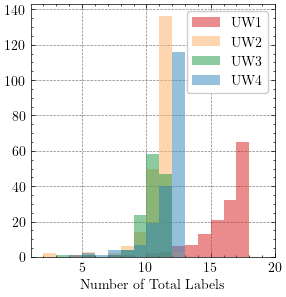

In [72]:
fig, ax = plt.subplots(figsize = (3,3))

for ii, ds_key in enumerate(ds_keys):
    ax.hist(dataset_dict_weekly[ds_key].datapoints.groupby("pid").count().values[:,0], 
            bins = np.linspace(1,20,20),
            color = colors[ii], alpha = 0.5)
    
ax.legend(["UW1","UW2","UW3","UW4"], ncol = 1, loc=0)

plt.tight_layout()
ax.set_xlabel("Number of Total Labels")
ax.set_xlim((1,20))
fig.patch.set_facecolor('white')
fig.patch.set_alpha(0)
plt.savefig("../plots/hist_labelcounts_neurips.pdf", dpi = 300, bbox_inches = "tight")
plt.show()

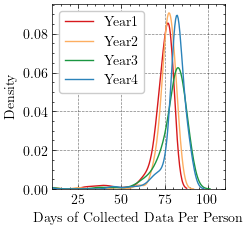

In [73]:
fig, ax = plt.subplots(figsize = (2.5,2.5))

for ii, ds_key in enumerate(ds_keys):
    sns.distplot(dataset_dict_raw_filtered[ds_key].groupby("pid").count().values.max(axis=1), hist=False, ax = ax, color = colors[ii])
    
ax.legend(["Year1","Year2","Year3","Year4"], ncol = 1, loc=0,)# bbox_to_anchor=(0.5, -0.07, 0.0, 0.5))

ax.set_xlabel("Days of Collected Data Per Person")
ax.set_xlim((10,110))
plt.tight_layout()
fig.patch.set_facecolor('white')
fig.patch.set_alpha(0)
plt.savefig("../plots/hist_datacounts_neurips.pdf", dpi = 300, bbox_inches = "tight")
plt.show()

# Feature Analysis

## Feature Value distribution

In [68]:
example_features = {
    "f_loc:phone_locations_barnett_siglocsvisited:14dhist": "[Location] (2wks)\nAverage Number of Frequent Locations",
    "f_screen:phone_screen_rapids_sumdurationunlock_locmap_home:14dhist": "[PhoneUsage] (whole day)\nTotal Duration of Unlock Episodes",
    "f_steps:fitbit_steps_intraday_rapids_sumsteps:allday": "[Activity] (whole day)\nNumber of Steps",
    "f_slp:fitbit_sleep_summary_rapids_avgdurationasleepmain:14dhist": "[Sleep] (2wks)\nAverage Duration Asleep",
    "f_call:phone_calls_rapids_outgoing_meanduration:14dhist": "[Call] (2wks)\n Average duration of Daily Outgoing Call",
    "f_blue:phone_bluetooth_doryab_meanscansothers:allday": "[Bluetooth] (2wks)\n Number of Unique Devices"
    
}

xlabels_dict = {
    "f_loc:phone_locations_barnett_siglocsvisited:14dhist": "Count",
    "f_screen:phone_screen_rapids_sumdurationunlock_locmap_home:14dhist": "Hours",
    "f_steps:fitbit_steps_intraday_rapids_sumsteps:allday": "Count / Thousand",
    "f_slp:fitbit_sleep_summary_rapids_avgdurationasleepmain:14dhist": "Hours",
    "f_call:phone_calls_rapids_outgoing_meanduration:14dhist": "Mins",
    "f_blue:phone_bluetooth_doryab_meanscansothers:allday": "Count",
    
}

scale_dict = {
    "f_loc:phone_locations_barnett_siglocsvisited:14dhist": 14,
    "f_screen:phone_screen_rapids_sumdurationunlock_locmap_home:14dhist": 60*14,
    "f_steps:fitbit_steps_intraday_rapids_sumsteps:allday": 1000,
    "f_slp:fitbit_sleep_summary_rapids_avgdurationasleepmain:14dhist": 60,
    "f_call:phone_calls_rapids_outgoing_meanduration:14dhist": 60,
    "f_blue:phone_bluetooth_doryab_meanscansothers:allday": 1,
}

x_range_dict = {
    "f_loc:phone_locations_barnett_siglocsvisited:14dhist": [0,3.7],
    "f_screen:phone_screen_rapids_sumdurationunlock_locmap_home:14dhist": [0,10],
    "f_steps:fitbit_steps_intraday_rapids_sumsteps:allday": [0,25],
    "f_slp:fitbit_sleep_summary_rapids_avgdurationasleepmain:14dhist": [4,10],
    "f_call:phone_calls_rapids_outgoing_meanduration:14dhist": [0,15],
    "f_blue:phone_bluetooth_doryab_meanscansothers:allday": [0,8],
}

y_lim_dict = {
    "f_loc:phone_locations_barnett_siglocsvisited:14dhist": [0,2.4],
    "f_screen:phone_screen_rapids_sumdurationunlock_locmap_home:14dhist": [0,0.32],
    "f_steps:fitbit_steps_intraday_rapids_sumsteps:allday": [0,0.215],
    "f_slp:fitbit_sleep_summary_rapids_avgdurationasleepmain:14dhist": [0,0.61],
    "f_call:phone_calls_rapids_outgoing_meanduration:14dhist": [0,0.4],
    "f_blue:phone_bluetooth_doryab_meanscansothers:allday": [0,1.01],
}

smooth_dict = {
    "f_loc:phone_locations_barnett_siglocsvisited:14dhist": 1,
    "f_screen:phone_screen_rapids_sumdurationunlock_locmap_home:14dhist": 1.5,
    "f_steps:fitbit_steps_intraday_rapids_sumsteps:allday": 1,
    "f_slp:fitbit_sleep_summary_rapids_avgdurationasleepmain:14dhist": 1.2,
    "f_call:phone_calls_rapids_outgoing_meanduration:14dhist": 1,
    "f_blue:phone_bluetooth_doryab_meanscansothers:allday": 1,
}

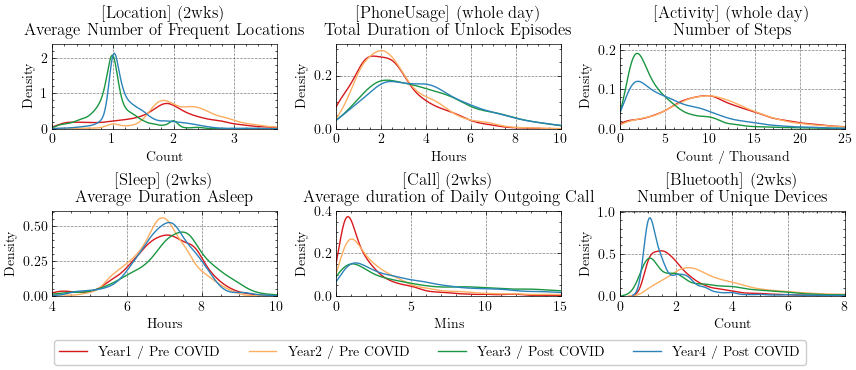

In [69]:
fig, axes = plt.subplots(figsize = (8.5,3.4), ncols = 3, nrows = 2)

for idx, feature in enumerate(example_features):
    ax = axes[idx//3][idx%3]
    feature_dict = {ds_key: dataset_dict_raw_filtered_withna[ds_key][feature].values / scale_dict[feature] for ds_key in ds_keys}
    
    for ii, ds_key in enumerate(ds_keys):
        if feature not in x_range_dict:
            sns.distplot(feature_dict[ds_key],  hist=False, ax = ax, color = colors[ii])
        else:
            sns.distplot([x for x in feature_dict[ds_key] if (x_range_dict[feature][0] * 0.9 < x and x < x_range_dict[feature][1] * 1.1)],
                         kde_kws={"bw_adjust":smooth_dict[feature]},
                         hist=False, ax = ax, color = colors[ii])
    ax.set_title(example_features[feature],fontsize=12)
    ax.set_xlabel(xlabels_dict[feature])
    ax.set_xlim(x_range_dict[feature])
    ax.set_ylim(y_lim_dict[feature])
    
fig.legend(["Year1 / Pre COVID","Year2 / Pre COVID","Year3 / Post COVID","Year4 / Post COVID"], ncol = 4, loc=8, bbox_to_anchor=(0.5, -0.1, 0.0, 0.5))

plt.tight_layout(pad=0.5)
fig.patch.set_facecolor('white')
fig.patch.set_alpha(0)
plt.savefig("../plots/singlefeat_pdf_examples_neurips.pdf", dpi = 300, bbox_inches = "tight")
plt.show()


### Feature Temporal Example

In [74]:
quarter_start_date = {
    1: "2018-03-26", 2: "2019-04-01",
    3: "2020-03-30", 4: "2021-03-29"}
date_range = {}
for phase in range(1,5):
    start_date = pd.to_datetime(quarter_start_date[phase])
    end_date = start_date + timedelta(days = 69)
    date_range[phase] = {"start": start_date, "end": end_date}

In [75]:
nanosecond_xticks = np.array([0, 60480, 120960, 181440,
                     241920, 302400, 362880,
                     423360, 483840, 544320]) * 1e10
nanosecond_xticks_weekend = np.array([0, 60480, 120960, 181440,
                     241920, 302400, 362880,
                     423360, 483840, 544320]) * 1e10 + 5 * 24 * 3600 * 1e9


In [76]:
scale_dict = {
"f_loc:phone_locations_barnett_disttravelled:allday": 1000,
"f_steps:fitbit_steps_intraday_rapids_sumsteps:allday":1000,
"f_slp:fitbit_sleep_summary_rapids_avgdurationinbedmain:allday": 60,
}

y_label_dict = {
"f_loc:phone_locations_barnett_disttravelled:allday": "Distance / km",
"f_steps:fitbit_steps_intraday_rapids_sumsteps:allday": "Count / thousands",
"f_slp:fitbit_sleep_summary_rapids_avgdurationinbedmain:allday": "Duration / hrs",
}

y_lim_dict = {
"f_loc:phone_locations_barnett_disttravelled:allday": [-2,62],
"f_steps:fitbit_steps_intraday_rapids_sumsteps:allday": [2.6,13],
"f_slp:fitbit_sleep_summary_rapids_avgdurationinbedmain:allday": [6.9,8.5]
}

title_dict = {
"f_loc:phone_locations_barnett_disttravelled:allday": "[Location] Travel Distance",
"f_steps:fitbit_steps_intraday_rapids_sumsteps:allday": "[Activity] Step Count",
"f_slp:fitbit_sleep_summary_rapids_avgdurationinbedmain:allday": "[Sleep] Duration in Bed",
}

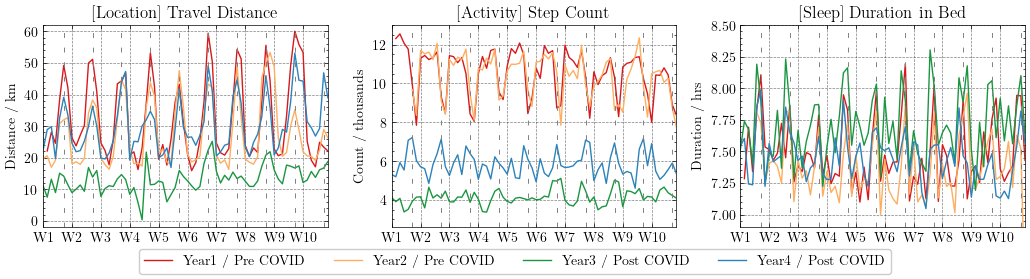

In [77]:
fig, axes = plt.subplots(figsize = (10.5,2.7), ncols=3)

df_plot_data = {}
for idx_feature, feature in enumerate(scale_dict):
    ax = axes[idx_feature]
    df_plot_data_feature = {}
    for i, ds_key in enumerate(ds_keys):
        ins, phase = ds_key.split("_")
        phase = int(phase)
        data_tmp = deepcopy(dataset_dict_raw_filtered_withna[ds_key][["date",feature]])
        low, high = np.nanpercentile(data_tmp[feature], q = [2.5, 97.5])
        data_tmp = data_tmp[(low < data_tmp[feature]) & (data_tmp[feature] < high)]
        data = data_tmp.groupby("date")[feature].mean() / scale_dict[feature]
        data_in_range = data.loc[data.index[(date_range[phase]["start"] <= data.index) & (data.index <= date_range[phase]["end"])]]
        data_in_range.index = data_in_range.index - date_range[phase]["start"]
        df_plot_data_feature[ds_key] = deepcopy(data_in_range)
        data_in_range.plot(ax = ax, color = colors[i], label = "Year" + str(phase))
    df_plot_data[feature] = pd.DataFrame(df_plot_data_feature)
    ax.set_xticks(nanosecond_xticks)
    ax.set_xticklabels(["W" + str(i) for i in range(1,11)])
    ax.set_xlabel("")
    ax.set_ylabel(y_label_dict[feature])
    ax.set_ylim(y_lim_dict[feature])
    ax.set_title(title_dict[feature])
    for x in nanosecond_xticks_weekend:
        ax.axvline(x, linewidth = 0.7, color = "gray", linestyle = (0, (5, 10)))
    ax.tick_params(axis='x', which='minor', bottom=False, top = False)
fig.legend(["Year1 / Pre COVID","Year2 / Pre COVID","Year3 / Post COVID","Year4 / Post COVID"], ncol = 4, loc=8, bbox_to_anchor=(0.5, -0.08, 0.0, 0.5))
plt.tight_layout()
plt.savefig("../plots/singlefeat_timeseries_examples_neurips.pdf", dpi = 300, bbox_inches = "tight")
plt.show()

## Label Distribution

In [78]:
label_endterm_dict = {ds_key:[] for ds_key in ds_keys}
label_weekly_dict = {ds_key:[] for ds_key in ds_keys}
for ds_key in ds_keys:
    for idx, row in dataset_dict_weekly[ds_key].datapoints.iterrows():
        yraw = row["y_allraw"]
        if ("BDI2" in yraw and not pd.isna(yraw["BDI2"])):
            label_endterm_dict[ds_key].append(yraw["BDI2"])
        if ("phq4" in yraw and not pd.isna(yraw["phq4"])):
            label_weekly_dict[ds_key].append(yraw["phq4"])

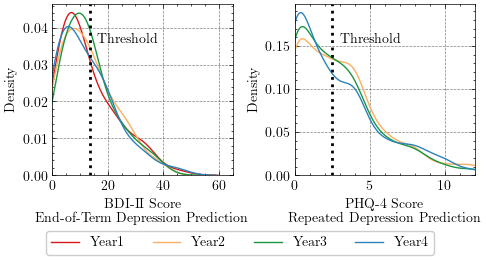

In [79]:
fig, axes = plt.subplots(figsize = (5,2.5), ncols = 2)

ax = axes[0]
for ii, ds_key in enumerate(ds_keys):
    sns.distplot(label_endterm_dict[ds_key], hist=False, bins = np.linspace(0,63,16), ax = ax, color = colors[ii], kde_kws={"bw_adjust": 1.2})
ax.set_xlabel("BDI-II Score\nEnd-of-Term Depression Prediction")
ax.set_xlim((0,65))
fig.legend(["Year1","Year2","Year3","Year4"], ncol = 4, loc = 'lower center', bbox_to_anchor=(0.5, -0.09, 0.0, 0.5))
ax.axvline(x = 13.5, color = "black", linestyle = ":", linewidth = 2)
ax.text(x = 16, y = 0.78 * ax.get_ylim()[1], s = "Threshold")
ax.set_ylabel("Density")
    
ax = axes[1]
for ii, ds_key in enumerate(ds_keys):
    sns.distplot(label_weekly_dict[ds_key], hist=False, bins = np.linspace(0,12,13), ax = ax, color = colors[ii], kde_kws={"bw_adjust": 1.2})
ax.set_xlabel("PHQ-4 Score\nRepeated Depression Prediction")
ax.set_xlim((0,12))
ax.axvline(x = 2.5, color = "black", linestyle = ":", linewidth = 2)
ax.text(x = 3, y = 0.78 * ax.get_ylim()[1], s = "Threshold")
ax.set_ylabel("Density")

plt.tight_layout()
fig.patch.set_facecolor('white')
fig.patch.set_alpha(0)
plt.savefig("../plots/label_distribution_neurips.pdf", dpi = 300, bbox_inches = "tight")
plt.show()

## Feature - Label Correlation Analysis

In [30]:
def prep_data_repo_aggregate(dataset:DatasetDict, feature_list, flag_feature_norm = False) -> DataRepo:
    df_datapoints = dataset.datapoints
    @ray.remote
    def get_stats(df):
        median_tmp = pd.Series(data = df[feature_list].iloc[-14:].median().values, index = [f + "#median" for f in feature_list]).T
        mad_tmp = pd.Series(data = df[feature_list].iloc[-14:].mad().values, index = [f + "#mad" for f in feature_list]).T
        mean_tmp = pd.Series(data = df[feature_list].iloc[-14:].mean().values, index = [f + "#mean" for f in feature_list]).T
        std_tmp = pd.Series(data = df[feature_list].iloc[-14:].std().values, index = [f + "#std" for f in feature_list]).T
        return pd.concat([median_tmp, mad_tmp, mean_tmp, std_tmp])

    X_tmp = ray.get([get_stats.remote(df) for df in df_datapoints["X_raw"]])

    X_tmp = pd.DataFrame(X_tmp)
    X_tmp.index = df_datapoints.index

    # filter
    shape1 = X_tmp.shape
    X_tmp = X_tmp[X_tmp.isna().sum(axis = 1) < X_tmp.shape[1] / 2]  # filter very empty days
    shape2 = X_tmp.shape
    del_rows = shape1[0] - shape2[0]

    X = deepcopy(X_tmp)
    
    if (flag_feature_norm):
        scl = RobustScaler(quantile_range = (5,95), unit_variance = True).fit(X)
        X[X.columns] = scl.transform(X)

    print(f"filter {del_cols} cols and {del_rows} rows")
    print(f"NA rate: {100* X.isna().sum().sum() / X.shape[0] / X.shape[1]}%" )
    X = X.fillna(X.median())
    X = X.fillna(0) # for those completely empty features (e.g., one dataset does not have the feature)

    y = df_datapoints["y_raw"].loc[X.index]
    pids = df_datapoints["pid"].loc[X.index]

    data_repo = DataRepo(X=X, y=y, pids=pids)
    return data_repo

In [ ]:
datarepo_dict = {}
for ds_key in ds_keys:
    print(ds_key)
    datarepo_dict[ds_key] = prep_data_repo_aggregate(
        dataset_dict_weekly[ds_key],
        feature_list = feature_columns_filtered_timeranges)

In [ ]:
pearsonr_dict = []
for ds_key in ds_keys:
    for col in datarepo_dict[ds_key].X:
        rho, p = scipy.stats.pearsonr(datarepo_dict[ds_key].X[col],datarepo_dict[ds_key].y)
        pearsonr_dict.append({"ds_key": ds_key, "feature": col, "rho": rho, "p-value": p})

In [ ]:
pearsonr_dict_whole = []
for col in datarepo_dict[ds_key].X:
    X_list = []
    y_list = []
    for ds_key in ds_keys:
        X_list.append(datarepo_dict[ds_key].X[col].values)
        y_list.append(datarepo_dict[ds_key].y)
    rho, p = scipy.stats.pearsonr(np.concatenate(X_list),np.concatenate(y_list))
    pearsonr_dict_whole.append({"ds_key": "all", "feature": col, "rho": rho, "p-value": p})

In [ ]:
pearsonr_dict += pearsonr_dict_whole
df_pearsonr_dict = pd.DataFrame(pearsonr_dict)

In [ ]:
with open("../evaluation_output/correlation_analysis_df_pearsonr_dict.pkl", "wb") as f:
    pickle.dump(df_pearsonr_dict, f)

In [31]:
with open("../evaluation_output/correlation_analysis_df_pearsonr_dict.pkl", "rb") as f:
    df_pearsonr_dict = pickle.load(f)

In [32]:
significant_features = set(df_pearsonr_dict[(df_pearsonr_dict["p-value"] <= 0.05) & (df_pearsonr_dict["ds_key"] == "all")]["feature"])
df_pearsonr_dict_significant = df_pearsonr_dict[df_pearsonr_dict["feature"].isin(significant_features)]
strong_correlation_features_dict = df_pearsonr_dict_significant.groupby(["ds_key"]).apply(lambda x : set(x["feature"])).to_dict()

In [33]:
overlapping_features = strong_correlation_features_dict[ds_keys[0]]
for ds_key in ds_keys[1:]:
    overlapping_features = overlapping_features.intersection(strong_correlation_features_dict[ds_key])

In [34]:
overlapping_features_all = strong_correlation_features_dict["all"]

In [35]:
df_rho = []
for feature in overlapping_features_all:
    df_tmp = utils_operation.get_df_rows(df_pearsonr_dict, {"feature":feature})
    dict_tmp = {ds_key: rho for ds_key, rho in zip(ds_keys, df_tmp.set_index("ds_key").loc[ds_keys]["rho"].values)}
    dict_tmp_sign = {f"{ds_key}_sign": 1 if rho > 0 else -1 for ds_key, rho in zip(ds_keys, df_tmp.set_index("ds_key").loc[ds_keys]["rho"].values)}
    dict_tmp_sign_sum = sum(dict_tmp_sign.values())
    
    dict_tmp["all"] = utils_operation.get_df_rows(df_tmp, {"ds_key":"all"}).iloc[0]["rho"]
    dict_tmp["avg"] = np.mean(list(dict_tmp.values()))
    dict_tmp["feature"] = feature
    dict_tmp["same_sign"] = np.abs(dict_tmp_sign_sum) == len(ds_keys)
    df_rho.append(dict_tmp)
df_rho = pd.DataFrame(df_rho)
df_rho = df_rho.set_index('feature')
df_rho = df_rho[~df_rho["avg"].isna()]

In [36]:
best_feature = df_rho[df_rho["same_sign"]]["avg"].abs().sort_values(ascending = False).index
best_feature_median = [x for x in best_feature if "#median" in x]
best_feature_fts = {}
for feature in best_feature_median:
    ft = feature.split(":")[0]
    if ft not in best_feature_fts:
        best_feature_fts[ft] = []
    best_feature_fts[ft].append(feature)

In [37]:
features_display = {
"placeholder-slp":r"$\bf{[Sleep]}$",
'f_slp:fitbit_sleep_summary_rapids_avgdurationasleepmain:14dhist#median': r"(2wks) Duration of Being Asleep",
'f_slp:fitbit_sleep_intraday_rapids_maxdurationasleepunifiedmain:night#median': r"(Night) Max Duration of Asleep Episodes",
'f_slp:fitbit_sleep_intraday_rapids_ratiocountawakeunifiedwithinmain:morning#median': r"(Morning) Ratio of Being Awake",
    
"placeholder-steps":r"$\bf{[Activity]}$",
'f_steps:fitbit_steps_intraday_rapids_maxdurationactivebout:14dhist#median': r"(2wks) Max Duration of Avtive Episodes",
'f_steps:fitbit_steps_intraday_rapids_maxdurationsedentarybout:14dhist#median': r"(2wks) Max Duration of Sedentary Episodes",
'f_steps:fitbit_steps_summary_rapids_maxsumsteps:14dhist#median': r"(2wks) Step Counts",

"placeholder-loc":r"$\bf{[Location]}$",
'f_loc:phone_locations_locmap_percent_in_locmap_exercise:allday#median': r"(AllDay) Percentage at Sports Area",
"f_loc:phone_locations_doryab_numberofsignificantplaces:14dhist#median": r"(2wks) Number of Frequent Locations",
'f_loc:phone_locations_doryab_timeathome_norm:allday#median': r"(AllDay) Duration at Home",

"placeholder-screen":r"$\bf{[PhoneUage]}$",
'f_screen:phone_screen_rapids_countepisodeunlock:night#median': r"(Night) Count of Unlock Episodes",
'f_screen:phone_screen_rapids_firstuseafter00unlock_locmap_home:allday#median': r"(AllDay) Unlock Timestamp at Home",
'f_screen:phone_screen_rapids_sumdurationunlock_locmap_home_norm:morning#median': r"(Morning) Total Duration of Unlock Episodes",

"placeholder-blue":r"$\bf{[Bluetooth]}$",
'f_blue:phone_bluetooth_doryab_countscansothers:allday#median': r"(AllDay) Number of Not-Self Devices",
'f_blue:phone_bluetooth_rapids_uniquedevices:evening#median': r"(Evening) Number of Unique Devices",
'f_blue:phone_bluetooth_doryab_countscansmostfrequentdevicewithinsegmentsall:allday#median': "(AllDay) Number of Most Frequent Devices",
    
"placeholder-call":r"$\bf{[Call]}$",
'f_call:phone_calls_rapids_outgoing_minduration:night#median': r"(Night) Min Duration of Outgoing Calls",
'f_call:phone_calls_rapids_outgoing_countmostfrequentcontact:allday#median': r"(AllDay) Count of Outgoing Calls of Freq Contacts",
'f_call:phone_calls_rapids_incoming_countmostfrequentcontact:evening#median': r"(Evening) Count of Incoming Calls of Freq Contacts",
}

for f in features_display:
    if f not in df_rho.index:
        df_rho.loc[f] = 0

In [38]:
selected_features = list(df_rho.loc[features_display.keys()]["avg"].abs().sort_values().index)
df_err = df_rho[ds_keys].std(axis=1).rename(index=features_display) / len(ds_keys)

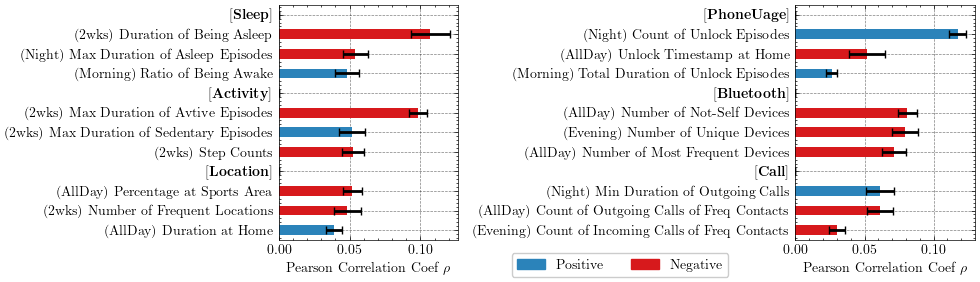

In [80]:
fig, axes = plt.subplots(figsize = (10,3), ncols = 2)

rows = list(features_display.keys())[::-1]
rows_first_half = rows[len(rows)//2:]
rows_second_half = rows[:len(rows)//2]

df_rho.loc[rows_first_half].rename(index=features_display)["avg"].abs().plot.barh(
    ax=axes[0],
    xerr=df_err,
    error_kw=dict(lw=2, capsize=3, capthick=1),
    color = ["#2b83ba" if x else "#d7191c" for x in df_rho.loc[rows_first_half]["avg"] > 0],
)

df_rho.loc[rows_second_half].rename(index=features_display)["avg"].abs().plot.barh(
    ax=axes[1],
    xerr=df_err,
    error_kw=dict(lw=2, capsize=3, capthick=1),
    color = ["#2b83ba" if x else "#d7191c" for x in df_rho.loc[rows_second_half]["avg"] > 0],
)

axes[0].set_xlabel(r"Pearson Correlation Coef $\rho$")
axes[0].set_ylabel("")
axes[1].set_xlabel(r"Pearson Correlation Coef $\rho$")
axes[1].set_ylabel("")

for idx, feature in enumerate(rows_first_half):
    if (not feature.startswith(" ") and feature != ""):
        axes[0].get_yticklabels()[idx].set_color("black")
for idx, feature in enumerate(rows_second_half):
    if (not feature.startswith(" ") and feature != ""):
        axes[1].get_yticklabels()[idx].set_color("black")

fig.patch.set_facecolor('white')
fig.patch.set_alpha(0)

import matplotlib.patches as mpatches
neg_patch = mpatches.Patch(color='#d7191c', label='Negative')
pos_patch = mpatches.Patch(color='#2b83ba', label='Positive')

fig.legend(handles=[pos_patch,neg_patch], ncol=2, loc='lower center', bbox_to_anchor=(0.63, 0.02, 0.0, 0.5))

plt.tight_layout()
plt.savefig("../plots/singlefeat_significant_correlation_examples_neurips.pdf", dpi = 300, bbox_inches = 'tight')
plt.show()

# Domain Distinguish

In [45]:
from imblearn.over_sampling import ADASYN, RandomOverSampler, SMOTE
from imblearn.pipeline import make_pipeline

## Feature Preparation

In [46]:
X_dict = {k: v.values[:,1:] for k ,v in dataset_dict_raw_filtered.items()}
dataset_dict = {k: [k for _ in range(len(v))] for k,v in dataset_dict_raw_filtered.items()}
pids_dict = {k: v["pid"] for k,v in dataset_dict_raw_filtered.items()}

In [47]:
person_list_dict = {k:sorted(list(set(v))) for k, v in pids_dict.items()}
person_dict_tmp = {p:{"k":k,"i":np.where(pids_dict[k] == p)[0]} for k,v in person_list_dict.items() for p in v}

# each pid is mappped to a person idx, with their data_idx in the df
# later train/test split will be based on pid
person_dict = {}
person_counter = 0
for pid in itertools.chain.from_iterable(itertools.zip_longest(*list(person_list_dict.values()))):
    if (not pid): continue
    person_dict[pid] = {"person_idx": person_counter, "dataset_key": person_dict_tmp[pid]["k"], "data_idx": person_dict_tmp[pid]["i"]}
    person_counter += 1
person_idx_dict = {k: np.array([person_dict[p]["person_idx"] for p in v]) for k, v in pids_dict.items()}
person_list = list(person_dict.keys())

In [48]:
total_num_pids = len(person_dict)
train_num_pids = int(0.8 * total_num_pids)
average_num_days = int(np.ceil(np.mean([len(d["data_idx"]) for p, d in person_dict.items()])))

In [49]:
print(total_num_pids, train_num_pids, average_num_days)

705 564 78


## Dataset as Domain

In [ ]:

def dataset_classification(features: List[str], random_state: int = 42):
    np.random.seed(random_state)

    df_results_record = []
    idx_split_dict = {}
    pid_split_dict = {}

    clf_type = "rf"
    clf_params = {"n_estimators": 10, "max_depth": 3}

    for ds_key in ds_keys:
        pid_train, pid_test = train_test_split(person_list_dict[ds_key], test_size=0.2)
        idx_train = np.concatenate([person_dict[pid]["data_idx"] for pid in pid_train])
        idx_test = np.concatenate([person_dict[pid]["data_idx"] for pid in pid_test])
        idx_split_dict[ds_key] = {"train": idx_train, "test": idx_test}
        pid_split_dict[ds_key] = {"train": pid_train, "test": pid_test}

    X_test_dict = {}
    dataset_test_dict = {}
    for ds_key in ds_keys:
        idx_test = idx_split_dict[ds_key]["test"]

        X_test_dict[ds_key] = deepcopy(dataset_dict_raw_filtered[ds_key].iloc[idx_test][features].values)
        dataset_test_dict[ds_key] = np.array([ds_key for _ in range(len(idx_test))])

    X_test = np.concatenate(list(X_test_dict.values()))
    dataset_test = np.concatenate(list(dataset_test_dict.values()))

    for train_proportion in np.logspace(np.log10(1.4/train_num_pids),0,20):
        print(f"{train_proportion:.5f}", end = ",")
        num_repeat = 5
        # if (train_proportion == 1.0) # shorten training time:
            # num_repeat = 1
        for _repeat in range(num_repeat):
            X_train_dict = {}
            dataset_train_dict = {}
            for ds_key in ds_keys:
                pid_train_all = pid_split_dict[ds_key]["train"]
                num_pid_frac = train_proportion * len(pid_train_all)
                num_pid_train = int(np.ceil(num_pid_frac))
                pid_train = np.random.choice(pid_train_all,num_pid_train,replace = False)
                idx_train_tmp = np.concatenate([person_dict[pid]["data_idx"] for pid in pid_train])
                if (num_pid_frac < 1):
                    idx_train_num = int(np.ceil(len(idx_train_tmp) * num_pid_frac))
                    idx_train = np.random.choice(idx_train_tmp,idx_train_num,replace = False)
                else:
                    idx_train = idx_train_tmp
                X_train_dict[ds_key] = deepcopy(dataset_dict_raw_filtered[ds_key].iloc[idx_train][features].values)
                dataset_train_dict[ds_key] = np.array([ds_key for _ in range(len(idx_train))])

            X_train = np.concatenate(list(X_train_dict.values()))
            dataset_train = np.concatenate(list(dataset_train_dict.values()))
            min_count = min(pd.value_counts(dataset_train))
            clf = utils_ml.get_clf(clf_type = clf_type, parameters= clf_params)
            if (min_count == 1):
                pipeline = make_pipeline(RandomOverSampler(), clf)
            elif (min_count < 3):
                pipeline = make_pipeline(SMOTE(k_neighbors = 1), clf)
            else:
                pipeline = make_pipeline(SMOTE(k_neighbors = 2), clf)
            pipeline.fit(X_train, dataset_train)
            results_overall = utils_ml.results_report_sklearn_multiclass(clf = clf, X = X_test, y = dataset_test)
            results_overall["train_proportion"] = train_proportion
            results_overall["train_num"] = {k:v.shape[0] for k, v in X_train_dict.items()}
            results_overall["train_num_sum"] = sum(list(results_overall["train_num"].values()))
            df_results_record.append(results_overall)
    df_results_record = pd.DataFrame(df_results_record)
    return df_results_record

In [ ]:
with Pool(8) as pool:
    df_classification_dataset_norm = pool.starmap(dataset_classification, [(feature_columns_norm, i + 420) for i in range(8)])
with Pool(8) as pool:
    df_classification_dataset_nonorm = pool.starmap(dataset_classification, [(feature_columns_nonorm, i + 420) for i in range(8)])

In [ ]:
df_classification_dataset_norm = pd.concat(df_classification_dataset_norm)
df_classification_dataset_nonorm = pd.concat(df_classification_dataset_nonorm)

metric_list = ["acc", "precision", "recall", "f1-score"]
for metric in metric_list:
    cols = [f"{metric}#{ds_key}" for ds_key in ds_keys]
    df_classification_dataset_norm[f"{metric}#avg"] = df_classification_dataset_norm[cols].mean(axis=1)
    df_classification_dataset_nonorm[f"{metric}#avg"] = df_classification_dataset_nonorm[cols].mean(axis=1)

In [ ]:
# save file to save computation for the next round
df_classification_dataset_nonorm.to_csv("../evaluation_output/df_classification_dataset_nonorm_neurips.csv", index = False)
df_classification_dataset_norm.to_csv("../evaluation_output/df_classification_dataset_norm_neurips.csv", index = False)

In [ ]:
df_classification_dataset_nonorm = pd.read_csv("../evaluation_output/df_classification_dataset_nonorm_neurips.csv")
df_classification_dataset_norm = pd.read_csv("../evaluation_output/df_classification_dataset_norm_neurips.csv")

In [51]:
df_classification_dataset_norm_mean = df_classification_dataset_norm.groupby("train_proportion").mean()
df_classification_dataset_norm_sem = df_classification_dataset_norm.groupby("train_proportion").sem()

df_classification_dataset_nonorm_mean = df_classification_dataset_nonorm.groupby("train_proportion").mean()
df_classification_dataset_nonorm_sem = df_classification_dataset_nonorm.groupby("train_proportion").sem()

In [52]:
df_classification_dataset_nonorm_mean["user"] = np.array(df_classification_dataset_nonorm_mean.index) * 564

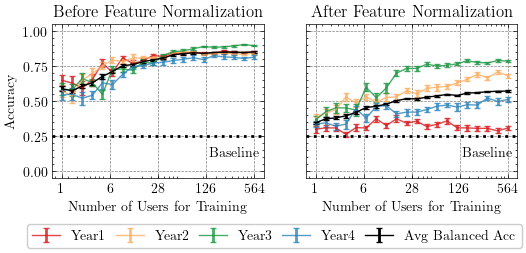

In [81]:
metric = "acc"
cols = [f"{metric}#{ds_key}" for ds_key in ds_keys]
fig, axes = plt.subplots(figsize = (6,2), ncols = 2)

ax = axes[0]

df_classification_dataset_nonorm_mean[cols].plot(ax = ax, alpha = 0.8,
    yerr = df_classification_dataset_nonorm_sem[cols], elinewidth = 2, capsize = 2, color = colors)
df_classification_dataset_nonorm_mean[[f"{'recall'}#avg"]].plot(ax = ax, alpha = 1,
    yerr = df_classification_dataset_nonorm_sem[[f"{'recall'}#avg"]], elinewidth = 2, capsize = 2, color = "#000000")
ax.set_xscale("log")
xticks = np.logspace(np.log10(1.4/train_num_pids),0,5)
ax.set_xticks(xticks)
ax.set_xticklabels([f"{round(i * train_num_pids)}" for i in xticks])
ax.set_xlabel("Number of Users for Training")
ax.set_ylabel("Accuracy")
ax.set_ylim((-0.05,1.05))
ax.legend(["Year1","Year2","Year3","Year4"] + ["Avg Balanced Acc"], ncol = 5, loc=8, bbox_to_anchor=(1.05, -0.5, 0.0, 0.5), columnspacing = 0.7)
ax.set_title("Before Feature Normalization")
ax.axhline(y = 0.25, linewidth = 2, linestyle = ":", color = "black")
ax.text(x = 0.18 * ax.get_xlim()[1], y = 0.10, s = "Baseline")

ax = axes[1]

df_classification_dataset_norm_mean[cols].plot(ax = ax, alpha = 0.8,
    yerr = df_classification_dataset_norm_sem[cols], elinewidth = 2, capsize = 2, color = colors)
df_classification_dataset_norm_mean[[f"{'recall'}#avg"]].plot(ax = ax, alpha = 1,
    yerr = df_classification_dataset_norm_sem[[f"{'recall'}#avg"]], elinewidth = 2, capsize = 2, color = "#000000")
ax.set_xscale("log")
xticks = np.logspace(np.log10(1.4/train_num_pids),0,5)
ax.set_xticks(xticks)
ax.set_xticklabels([f"{round(i * train_num_pids)}" for i in xticks])
ax.set_xlabel("Number of Users for Training")
# ax.set_ylabel("Accuracy")
ax.set_yticklabels([])
ax.set_ylim((-0.05,1.05))
ax.get_legend().remove()
ax.set_title("After Feature Normalization")
ax.axhline(y = 0.25, linewidth = 2, linestyle = ":", color = "black")
ax.text(x = 0.18 * ax.get_xlim()[1], y = 0.10, s = "Baseline")

fig.patch.set_facecolor('white')
fig.patch.set_alpha(0)
plt.savefig("../plots/results_dataset_distinguish_neurips_narrow.pdf", dpi = 300, bbox_inches = "tight")
plt.show()

## Person as Domain

In [ ]:
def person_classification(features: List[str], random_state: int = 42):
    np.random.seed(random_state)

    clf_type = "rf"
    clf_params = {"n_estimators": 10, "max_leaf_nodes": 2 ** 11}    

    person_dict_train = deepcopy(person_dict)
    person_dict_test = deepcopy(person_dict)

    for p, info in person_dict.items():
        data_idx_train, data_idx_test = train_test_split(info["data_idx"], test_size = 0.2)
        person_dict_train[p]["data_idx"] = data_idx_train
        person_dict_test[p]["data_idx"] = data_idx_test

    df_results_record = []
    X_test_dict = {}
    pids_test_dict = {}
    for ds_key in ds_keys:
        idx_test = np.concatenate([person_dict_test[p]["data_idx"] for p in person_list_dict[ds_key]])

        X_test_dict[ds_key] = deepcopy(dataset_dict_raw_filtered[ds_key].iloc[idx_test][features].values)
        pids_test_dict[ds_key] = deepcopy(dataset_dict_raw_filtered[ds_key]["pid"].iloc[idx_test])

    X_test = np.concatenate(list(X_test_dict.values()))
    pids_test = np.concatenate(list(pids_test_dict.values()))

    for train_proportion in np.logspace(np.log10(1.4/average_num_days),0,20):
        print(f"{train_proportion:.5f}", end = ",")
        num_repeat = 1
        for _repeat in range(num_repeat):
            X_train_dict = {}
            pids_train_dict = {}
            for ds_key in ds_keys:
                idx_train = []
                for p in person_list_dict[ds_key]:
                    idx_train_origin = person_dict_train[p]["data_idx"]
                    num_sample_frac = train_proportion * len(idx_train_origin)
                    num_sample_train = int(np.ceil(num_sample_frac))
                    idx_train.append(np.random.choice(idx_train_origin,num_sample_train,replace = False))
                idx_train = np.concatenate(idx_train)
                X_train_dict[ds_key] = deepcopy(dataset_dict_raw_filtered[ds_key].iloc[idx_train][features].values)
                pids_train_dict[ds_key] = deepcopy(dataset_dict_raw_filtered[ds_key]["pid"].iloc[idx_train])

            X_train = np.concatenate(list(X_train_dict.values()))
            pids_train = np.concatenate(list(pids_train_dict.values()))

            clf = utils_ml.get_clf(clf_type = clf_type, parameters= clf_params)

            min_count = min(pd.value_counts(pids_train))
            if (min_count == 1):
                pipeline = make_pipeline(RandomOverSampler(), clf)
            elif (min_count < 3):
                pipeline = make_pipeline(SMOTE(k_neighbors = 1), clf)
            else:
                pipeline = make_pipeline(SMOTE(k_neighbors = 2), clf)
            pipeline.fit(X_train, pids_train)
            results_overall = utils_ml.results_report_sklearn_multiclass(clf = clf, X = X_test, y = pids_test)
            results_overall["train_proportion"] = train_proportion
            results_overall["train_num"] = {k:v.shape[0] for k, v in X_train_dict.items()}
            results_overall["train_num_sum"] = sum(list(results_overall["train_num"].values()))
            df_results_record.append(results_overall)
    df_results_record = pd.DataFrame(df_results_record)
    return df_results_record

In [ ]:
with Pool(8) as pool:
    df_classification_person_nonorm = pool.starmap(person_classification, [(feature_columns_nonorm, i) for i in range(8)])
with Pool(8) as pool:
    df_classification_person_norm = pool.starmap(person_classification, [(feature_columns_norm, i) for i in range(8)])

In [ ]:
df_classification_person_norm = pd.concat(df_classification_person_norm)
df_classification_person_nonorm = pd.concat(df_classification_person_nonorm)

In [ ]:
cols_dict = {k : [] for k in ds_keys}
for c in list(df_classification_person_nonorm.columns):
    if c.count("#") != 2: continue
    m, pid, k = c.split("#")
    cols_dict[k].append(f"{pid}#{k}")
for k, cols in cols_dict.items():
    cols_dict[k] = sorted(list(set(cols)))

In [ ]:
metric_list = ["acc", "precision", "recall", "f1-score"]
for metric in metric_list:
    for k, cols_raw in cols_dict.items():
        cols = [f"{metric}#{key}" for key in cols_raw]
        df_classification_person_norm[f"{metric}#{k}#avg"] = df_classification_person_norm[cols].mean(axis=1)
        df_classification_person_nonorm[f"{metric}#{k}#avg"] = df_classification_person_nonorm[cols].mean(axis=1)
    cols_all = np.concatenate(list(cols_dict.values()))
    cols = [f"{metric}#{key}" for key in cols_all]
    df_classification_person_norm[f"{metric}#avg"] = df_classification_person_norm[cols].mean(axis=1)
    df_classification_person_nonorm[f"{metric}#avg"] = df_classification_person_nonorm[cols].mean(axis=1)

In [ ]:
# save file to save computation for the next round
df_classification_person_nonorm.to_csv("../evaluation_output/df_classification_person_nonorm_neurips.csv", index = False)
df_classification_person_norm.to_csv("../evaluation_output/df_classification_person_norm_neurips.csv", index = False)

In [54]:
df_classification_person_nonorm = pd.read_csv("../evaluation_output/df_classification_person_nonorm_neurips.csv")
df_classification_person_norm = pd.read_csv("../evaluation_output/df_classification_person_norm_neurips.csv")

In [55]:
df_classification_person_nonorm_mean = df_classification_person_nonorm.groupby("train_proportion").mean()
df_classification_person_nonorm_sem = df_classification_person_nonorm.groupby("train_proportion").sem()

df_classification_person_norm_mean = df_classification_person_norm.groupby("train_proportion").mean()
df_classification_person_norm_sem = df_classification_person_norm.groupby("train_proportion").sem()

In [56]:
df_classification_person_nonorm_mean["day"] = np.array(df_classification_person_nonorm_mean.index) * 78

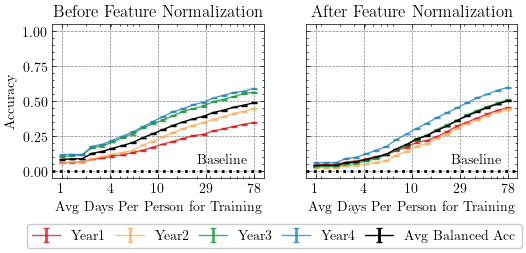

In [82]:
metric = "acc"
cols = [f"{metric}#{ds_key}#avg" for ds_key in ds_keys]
fig, axes = plt.subplots(figsize = (6,2), ncols = 2)

ax = axes[0]

df_classification_person_nonorm_mean[cols].plot(ax = ax, alpha = 0.8,
    yerr = df_classification_person_nonorm_sem[cols], elinewidth = 2, capsize = 2, color = colors)
df_classification_person_nonorm_mean[[f"{'recall'}#avg"]].plot(ax = ax, alpha = 1,
    yerr = df_classification_person_nonorm_sem[[f"{'recall'}#avg"]], elinewidth = 2, capsize = 2, color = "#000000")
ax.set_xscale("log")
xticks = np.logspace(np.log10(1.4/average_num_days),0,5)
ax.set_xticks(xticks)
ax.set_xticklabels([f"{round(i * average_num_days)}" for i in xticks])
ax.set_xlabel("Avg Days Per Person for Training")
ax.set_ylabel("Accuracy")
ax.set_ylim((-0.05,1.05))
ax.legend(["Year1","Year2","Year3","Year4"] + ["Avg Balanced Acc"], ncol = 5, loc=8, bbox_to_anchor=(1.05, -0.5, 0.0, 0.5), columnspacing = 0.7)
ax.set_title("Before Feature Normalization")
ax.axhline(y = 1/total_num_pids, linewidth = 2, linestyle = ":", color = "black")
ax.text(x = 0.25 * ax.get_xlim()[1], y = 0.05, s = "Baseline")

ax = axes[1]

df_classification_person_norm_mean[cols].plot(ax = ax, alpha = 0.8,
    yerr = df_classification_person_norm_sem[cols], elinewidth = 2, capsize = 2, color = colors)
df_classification_person_norm_mean[[f"{'recall'}#avg"]].plot(ax = ax, alpha = 1,
    yerr = df_classification_person_norm_sem[[f"{'recall'}#avg"]], elinewidth = 2, capsize = 2, color = "#000000")
ax.set_xscale("log")
ax.set_xticks(xticks)
ax.set_xticklabels([f"{round(i * average_num_days)}" for i in xticks])
ax.set_xlabel("Avg Days Per Person for Training")
# ax.set_ylabel("Accuracy")
ax.set_yticklabels([])
ax.set_ylim((-0.05,1.05))
# ax.legend(False)
ax.get_legend().remove()
ax.set_title("After Feature Normalization")
ax.axhline(y = 1/total_num_pids, linewidth = 2, linestyle = ":", color = "black")
ax.text(x = 0.25 * ax.get_xlim()[1], y = 0.05, s = "Baseline")

fig.patch.set_facecolor('white')
fig.patch.set_alpha(0)
plt.savefig("../plots/results_person_distinguish_neurips_narrow.pdf", dpi = 300, bbox_inches = "tight")
plt.show()